# Converting events to actions

Each event data provider uses a proprietary format to describe the events that happend during a game. Socceraction, in contrast, uses a standardized tabular action-oriented data format, called SPADL. The distinction is that actions are a subset of events that require a player to perform the action. For example, a "shot" is an action, whereas an event signifying the end of the game is not an action. Additionally, SPADL always store the same attributes for each action. Excluding optional information snippets enables us to store the data in a table and more easily apply automatic analysis tools.

SoccerAction implements two versions of this action-oriented data format: SPADL and Atomic-SPADL. For a detailed description of these formats, [see the documentation](https://socceraction.readthedocs.io/en/latest/documentation/spadl/index.html).

This notebook illustrates how to convert the provider-specific events to the SPADL and Atomic-SPADL representations. 

## Load dataset
We will user our dataset with StatsBomb events of the Big 5 leagues in 2015/16. The `1.1-load-statsbomb-data` notebook explains how to create this dataset.

In [1]:
from pathlib import Path
from socceraction.data import HDFDataset, PartitionIdentifier

data_dir = Path("../../data")

# Open a HDF dataset
dataset = HDFDataset(
    path=(data_dir / "statsbomb-bigfive-1516.h5"), 
    mode="a"  # we open the HDF file in "a[ppend]" mode such that we can add data
)

## SPADL representation of event data

SPADL (*Soccer Player Action Description Language*) represents a game as a sequence of on-the-ball actions $[a_1, a_2, . . . , a_m]$, where $m$ is the total number of actions that happened in the game. Each action is a tuple of the same 14 attributes. All actions, except for some dribbles, are derived from an event in the original event stream data. Socceraction currently implements converters for StatsBomb, Wyscout, and Opta event stream data.

In [2]:
from socceraction.data.transforms import StatsBombEventsToActions
from socceraction import spadl

to_actions = StatsBombEventsToActions(xy_fidelity_version=2, shot_fidelity_version=2)

We can do the conversion for a single game.

In [3]:
game = dataset.games().query("game_id==3754003").iloc[0]
events = dataset.events(game_id=3754003)

In [4]:
df_actions = to_actions(game, events)
df_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,3754003,62a30bca-fd29-46f2-86e8-02b009ed2cfa,1,0.381,24,3535.0,51.66875,34.0425,51.05625,36.7625,0,1,5,0
1,3754003,fe87af88-d765-4172-85d1-beb8cb2bae6c,1,1.007,24,3493.0,51.05625,36.7625,54.81875,35.6575,21,1,0,1
2,3754003,619fa6d8-2d84-459d-a145-8f0d3be50a90,1,1.382,24,3493.0,54.81875,35.6575,72.31875,23.5025,0,1,5,2
3,3754003,67ab0daa-7fd8-47ca-86ea-93a1b285db10,1,2.948,24,3471.0,72.31875,23.5025,74.15625,27.8375,21,1,0,3
4,3754003,969c870f-69c5-4908-9ab5-a433341dd3e3,1,4.217,24,3471.0,74.15625,27.8375,93.75625,36.5925,0,1,4,4


With matplotsoccer (run `pip install matplotsoccer`), we can visualize a short sequence of actions. Below is Benteke's magnificent scissor-kick goal ([video](https://www.youtube.com/watch?v=3tBiQ79Ns5M)) in the game between Manchester United and Liverpool on 12 September 2015. Jordon Ibe picked up possession on the right wing and stabbed a cross into the box that Daley Blind could only half-clear. The ball hanging in the air, Benteke send the ball past David de Gea with and athletic scissor-kick.

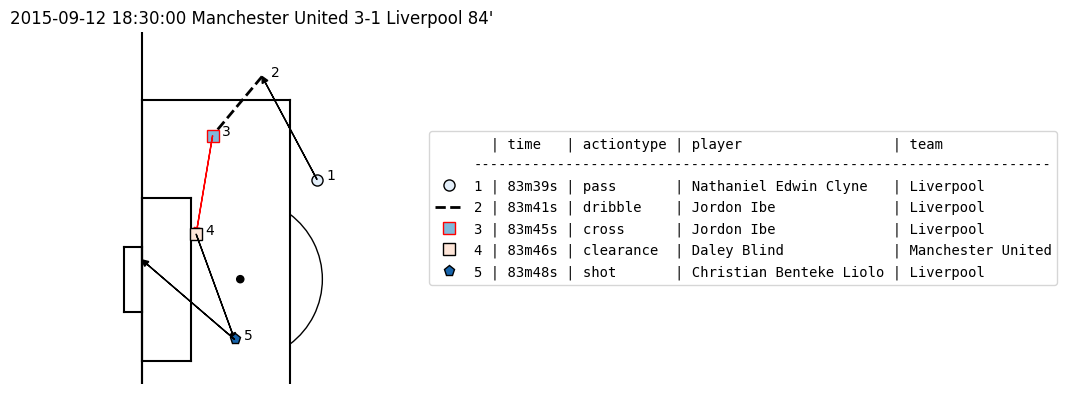

In [5]:
import matplotlib.pyplot as plt
import matplotsoccer

# Select the 5 actions preceding the goal
shot = 1987
a = (
    spadl.utils.add_names(df_actions.loc[shot-4:shot])
    .merge(dataset.teams(), on="team_id", how="left")
    .merge(dataset.players(), on="player_id", how="left")
)

# Print the game date and timestamp of the goal
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
home_team_name = dataset.get_team_name(game.home_team_id)
away_team_name = dataset.get_team_name(game.away_team_id)
game_info = f"{game.game_date} {home_team_name} {game.home_score}-{game.away_score} {away_team_name} {minute + 1}'"

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team=a.team_name,
    result=a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=True,
    figsize=4,
    show=False,
)
plt.title(game_info)
plt.show()

We can also apply the transformation to the full dataset. This will convert the events of each game to SPADL actions and store the result in a new "actions" table.

In [6]:
dataset.transform(to_actions, from_table="events", to_table="actions")

Transforming dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1823/1823 [24:59<00:00,  1.22it/s]


## Atomic-SPADL representation of event data

Atomic-SPADL is an alternative version of SPADL which removes the result attribute from SPADL and adds a few new action types. In this representation, all actions are atomic in the sense that they are always completed successfully without interruption. Consequently, while SPADL treats a pass as one action consisting of both the initiation and receival of the pass, Atomic-SPADL sees giving and receiving a pass as two separate actions. Because not all passes successfully reach a teammate, Atomic-SPADL introduces an interception action if the ball was intercepted by the other team or an out event if the ball went out of play. Atomic-SPADL similarly divides shots, freekicks, and corners into two separate actions. Practically, the effect is that this representation helps to distinguish the contribution of the player who initiates the action (e.g., gives the pass) and the player who completes the action (e.g., receives the pass).

In [7]:
from socceraction.data.transforms import ActionsToAtomic
from socceraction.atomic import spadl as atomic_spadl

to_atomic = ActionsToAtomic()

In [8]:
df_atomic_actions = to_atomic(game, df_actions)
df_atomic_actions.head()

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id
0,3754003,62a30bca-fd29-46f2-86e8-02b009ed2cfa,0,1,0.381,24,3535.0,51.66875,34.0425,-0.6125,2.720,0,5
1,3754003,62a30bca-fd29-46f2-86e8-02b009ed2cfa,1,1,0.694,24,3493.0,51.05625,36.7625,0.0000,0.000,23,0
2,3754003,fe87af88-d765-4172-85d1-beb8cb2bae6c,2,1,1.007,24,3493.0,51.05625,36.7625,3.7625,-1.105,21,0
3,3754003,619fa6d8-2d84-459d-a145-8f0d3be50a90,3,1,1.382,24,3493.0,54.81875,35.6575,17.5000,-12.155,0,5
4,3754003,619fa6d8-2d84-459d-a145-8f0d3be50a90,4,1,2.165,24,3471.0,72.31875,23.5025,0.0000,0.000,23,0


Again, we can visualize Benteke's goal.

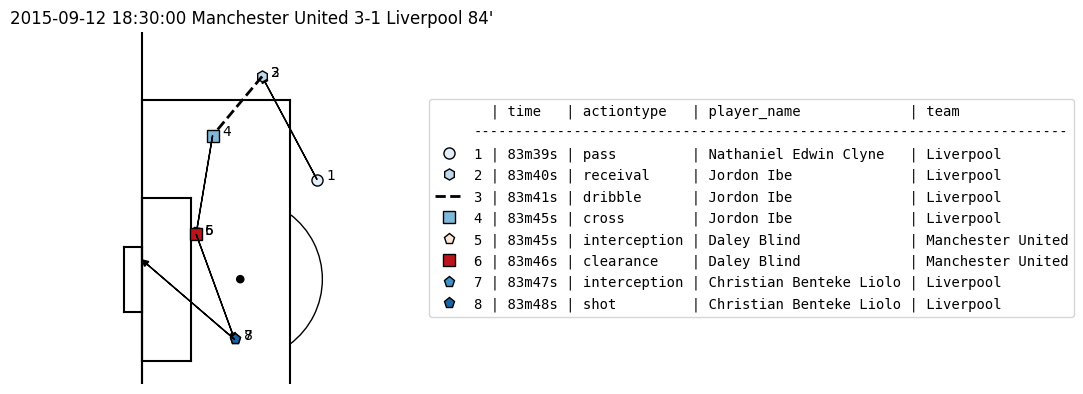

In [9]:
import matplotlib.pyplot as plt
import matplotsoccer

shot=2993
a = (
    atomic_spadl.add_names(df_atomic_actions[shot-8:shot])
    .merge(dataset.teams(), on="team_id", how="left")
    .merge(dataset.players(), on="player_id", how="left")
)

home_team_name = dataset.get_team_name(game.home_team_id)
away_team_name = dataset.get_team_name(game.away_team_id)

a["start_x"] = a.x
a["start_y"] = a.y
a["end_x"] = a.x + a.dx
a["end_y"] = a.y + a.dy

minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{game.game_date} {home_team_name} {game.home_score}-{game.away_score} {away_team_name} {minute + 1}'"

def nice_time(row):
    minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["time", "actiontype", "player_name", "team"],
    zoom=True,
    figsize=4,
    show=False
)
plt.title(game_info)
plt.show()

In [10]:
dataset.transform(to_atomic, from_table="actions", to_table="atomic_actions")

Transforming dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1823/1823 [05:18<00:00,  5.72it/s]


In [11]:
dataset.close()